### Day 16 - Proboscidea Volcanium

##### Part 1 - Release Valves

What is the most pressure that you can release in 30 minutes?

In [23]:
from collections import defaultdict

def get_data(input_file):
    with open(input_file, "r") as f:
        data = [ [a.strip(',') for a in line.split(" ")[1:] if a not in ['has', 'flow', 'tunnel', 'tunnels', 'lead','leads', 'to', 'valve', 'valves']] \
            for line in f.read().strip().split("\n")]
           
    D = {d[0] : (int(data[i][1][:-1].split("=")[1]), data[i][2:]) for i,d in enumerate(data)}

    flows = {d : D[d][0] for d in D.keys()}
    neighbors = {d : D[d][1] for d in D.keys()}
    valve_binary_map = {valve : 1 << i for i,valve in enumerate(D)}

    candle = 1 << (len(D))
    
    for valve in filter(lambda x : D[x][0] == 0, D.keys()):
        candle |= valve_binary_map[valve]
        
    return flows, neighbors, valve_binary_map, candle

In [24]:
cache = defaultdict()
input_file = "aoc_16_input.txt"
p1_flows, p1_neighbors, valve_binary_map, candle = get_data(input_file)

def dfs(node, timeRemaining, openedValves, currFlowRate):
    if timeRemaining == 0:                          
        return 0

    k = hash((timeRemaining, openedValves, node)) 
    if k in cache:                                  
        return cache[k]

    best = 0       
        # not already open, costs 1 min to open
    if not (openedValves & valve_binary_map[node]):
        best = max(best, dfs(node, timeRemaining - 1, openedValves | valve_binary_map[node], currFlowRate + p1_flows[node])  ) 

        # try neighbors, without opening
    for neighbor in p1_neighbors[node]:
        best = max(best,  dfs(neighbor, timeRemaining - 1, openedValves, currFlowRate)  )

    res = best + currFlowRate
    cache[hash((timeRemaining, openedValves, node))] = res

    return res

print(f"Part 1: Most pressure released = {dfs('AA', 30, candle, 0)}")

Part 1: Most pressure released = 1737


### Part 2

Spend 4 minutes training an elephant to help you open valves. Now what is the best the two of you can do in 26 minutes?

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

def yield_digraph(data):
    D = nx.Graph()
    D.add_nodes_from(data.keys() )
    D.add_weighted_edges_from([(valve, endpoint, 1) for valve in data for endpoint in data[valve] ])
        
    color_map = []
    for node, fr in D.nodes(data = "Flow rate"):
        if node =='AA':
            color_map.append("tab:green")
            continue
        elif fr == 0:
            color_map.append("white")
        else:
            color_map.append("tab:blue")
    
    plt.figure(1, figsize=(12,12))
    options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
    graph_pos = nx.spring_layout(D, k = 0.05, iterations=250, weight="weight")
    nx.draw_networkx_nodes(D, graph_pos, node_color=color_map, **options)
    nx.draw_networkx_labels(D, graph_pos, font_size=10)
    nx.draw_networkx_edges(D, graph_pos, edgelist=D.edges(), arrows=True, alpha=0.5)
    #labels = nx.get_edge_attributes(D, "weight")
    #nx.draw_networkx_edge_labels(D, graph_pos, edge_labels=labels)
    plt.show()
    return D

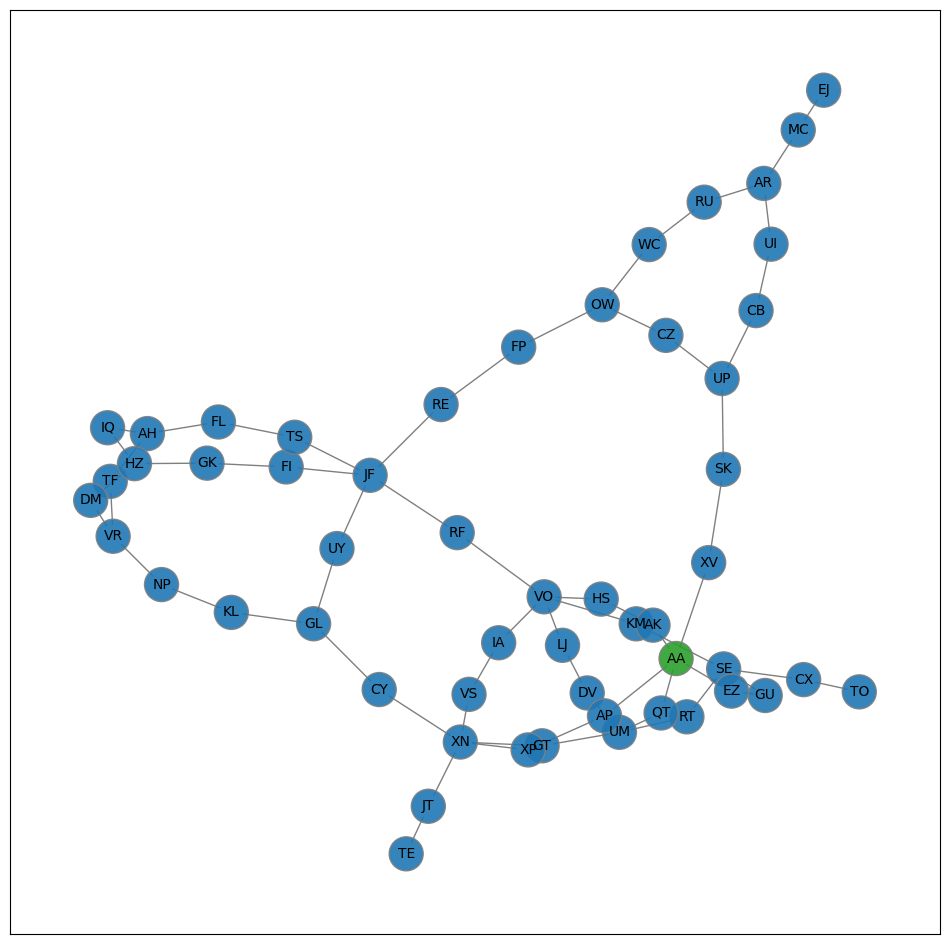

In [26]:
DG = yield_digraph(p1_neighbors)
# for now just displaying a graph for analysis
# will come back to part 2 later

In [27]:
cache_p2 = defaultdict()
input_file = "aoc_16_input.txt"
p2_flows, p2_neighbors, valve_binary_map, candle = get_data(input_file)
global_best = 0

def dfs_p2(node1, node2, timeRemaining, openedValves, currFlowRate):
    #if timeRemaining == 0:       
    #    return 0
    if timeRemaining == 1:
        return currFlowRate
    
    lexi_A, lexi_B = min(node1, node2), max(node1, node2)
    k = hash((timeRemaining, openedValves, lexi_A, lexi_B)) 
    if k in cache_p2:                                  
        return cache_p2[k]

    # four cases: 
    # - open open
    # - open walk
    # - walk open
    # - walk walk

    best = 0       
    if not (openedValves & valve_binary_map[node1]) and not (openedValves & valve_binary_map[node2]):
        # two distinct nodes, both unopen. compare opening them 
        if node1 != node2:
            best = max(best, dfs_p2(node1, node2, timeRemaining - 1, openedValves | valve_binary_map[node1] | valve_binary_map[node2], currFlowRate + p2_flows[node1] + p2_flows[node2]) )

    for nbr in p2_neighbors[node1]:
        # walk open 
        if not (openedValves & valve_binary_map[node2]):
            best = max(best, dfs_p2(nbr, node2, timeRemaining - 1, openedValves | valve_binary_map[node2], currFlowRate + p2_flows[node2]))
        # walk walk 
        for nbr2 in p2_neighbors[node2]:
            best = max(best, dfs_p2(nbr, nbr2, timeRemaining - 1, openedValves, currFlowRate))
            # open walk 
            if not (openedValves & valve_binary_map[node1]):
                best = max(best, dfs_p2(node1, nbr2, timeRemaining - 1, openedValves | valve_binary_map[node1], currFlowRate + p2_flows[node1]))


    res = best + currFlowRate
    global global_best
    if res > global_best:
        global_best = res
        print(f"{global_best}")
    cache_p2[hash((timeRemaining, openedValves, lexi_A, lexi_B))] = res

    return res

# This ends up taking way too long, need to find something more efficient. 
#print(f"Part 2: Most pressure released with an elephant friend (26 seconds): {dfs_p2('AA', 'AA', 3, candle, 0)}")

In [28]:
# Try learning and using Floyd-Warshall Algorithm

input_file = "aoc_16_input.txt"
p2_flows, p2_neighbors, valve_binary_map, candle = get_data(input_file)

# We don't want 0-flow valves opened
for k in list(p2_flows.keys()):
    if p2_flows[k] == 0:
        del p2_flows[k]

T = {x : {y : 1 if y in p2_neighbors[x] else float("inf") for y in p2_neighbors} for x in p2_neighbors}

for k in T:
    for i in T:
        for j in T:
            T[i][j] = min(T[i][j], T[i][k] + T[k][j])

def visit(v, budget, state, flow, ans):
    ans[state] = max(ans.get(state, 0), flow)
    for u in p2_flows:
        new_budget = budget - T[v][u] - 1
        if (valve_binary_map[u] & state) or (new_budget <= 0): 
            continue
        visit(u, new_budget, state | valve_binary_map[u], flow + new_budget * p2_flows[u], ans)
    return ans

p1_res = max(visit('AA', 30, 0, 0, defaultdict()).values())
print(f"Part 1: (Floyd-Warshall implementation) Maximum flow solo after 30 seconds is {p1_res}")

p2_res = visit('AA', 26, 0, 0, defaultdict())
best = 0
for m, u in p2_res.items():
    for n, v in p2_res.items():
        if not (n & m):
            best = max(best, u + v)
print(f"Part 2: (Floyd-Warshall implementation) Maximum flow w/ elephant after 26 seconds is {best}")



Part 1: (Floyd-Warshall implementation) Maximum flow solo after 30 seconds is 1737
Part 2: (Floyd-Warshall implementation) Maximum flow w/ elephant after 26 seconds is 2216
